# 1.花卉图像识别

## 1.1 实验介绍
本实验主要内容是进行花类图像的识别，用到的框架主要包括：cv2模块，专门用于图像处理，使用原生的 NumPy 数组作为图像对象；TensorFlow 2.0，主要用于深度学习算法的构建，这里主要用于卷积神经网络的搭建，主要以开源的花类数据集为基础，基于TensorFlow深度学习框架和卷积神经网络（CNN）对花的类型进行分类识别。

## 1.2 导入实验环境

### 1.2.1 导入相应的模块
cv2模块主要用于图像数据的处理，在该实验中
io模块主要用于图像数据的读取（imread）和输出（imshow）操作；
glob包主要用于查找符合特定规则的文件路径名，跟使用windows下的文件搜索差不多； 
os模块主要用于处理文件和目录，比如：获取当前目录下文件，删除制定文件，改变目录，查看文件大小等；
tensorflow是目前业界最流行的深度学习框架，在图像，语音，文本，目标检测等领域都有深入的应用，也是该实验的核心，主要用于定义占位符，定义变量，创建卷积神经网络模型；
numpy是一个基于python的科学计算包，在该实验中主要用来处理数值运算；

第三方包的安装方式，安装前更新pip:
python -m pip install --upgrade pip
pip install opencv-python # 对应cv2
pip install tensorflow
pip3 install matplotlib
pip3 install sklearn

In [1]:
import glob                # 用于查询符合特定规则的文件路径名
import os                  # 处理文件和目录
import cv2                 # 用于图像处理
import  tensorflow as tf
from tensorflow.keras import layers, optimizers, datasets, Sequential  #从tensorflow.keras模块下导入layers，optimizers, datasets, Sequential等方法
import numpy as np                #导入numpy数据库
import matplotlib.pyplot as plt   #导入matplotlib.pyplot模块，主要用于展示图像
from sklearn.model_selection import train_test_split   #从sklearn.model_selection模块导入train_test_split方法,用于拆分数据集

ModuleNotFoundError: No module named 'cv2'

### 1.2.2 设置初始化环境

In [38]:
path = './flower_photos/'   # 数据集的相对地址，改为你自己的，建议将数据集放入代码文件夹下
# TODO 对图片进行缩放，统一处理为大小为w*h的图像，具体参数需自己定
w = 10      #设置图片宽度为10
h = 10      #设置图片高度为10
c = 3        #设置图片通道为3

## 1.3 实验数据准备
花卉图像识别的数据集为一张张图片，Python不能一次性全量读取，所以我们要编写一个读取函数，利用函数批量读取图片数据集。

### 1.3.1 构建数据读取函数

In [39]:
def read_img(path):                                                    # 定义函数read_img，用于读取图像数据，并且对图像进行resize格式统一处理
    cate=[path+x for x in os.listdir(path) if os.path.isdir(path+x)]  # 创建层级列表cate，用于对数据存放目录下面的数据文件夹进行遍历，os.path.isdir用于判断文件是否是目录，然后对是目录的文件(os.listdir(path))进行遍历
    imgs=[]                                                            # 创建保存图像的空列表
    labels=[]                                                          # 创建用于保存图像标签的空列表
    for idx,folder in enumerate(cate):                                # enumerate函数用于将一个可遍历的数据对象组合为一个索引序列，同时列出数据和下标,一般用在for循环当中
        for im in glob.glob(folder+'/*.jpg'):                         # 利用glob.glob函数搜索每个层级文件下面符合特定格式“/*.jpg”的图片，并进行遍历
            #print('reading the images:%s'%(im))                      # 遍历图像的同时，打印每张图片的“路径+名称”信息
            img=cv2.imread(im)                                        # 利用cv2.imread函数读取每一张被遍历的图像并将其赋值给img
            img=cv2.resize(img,(w,h))                                 # 利用cv2.resize函数对每张img图像进行大小缩放，统一处理为大小为w*h的图像
            imgs.append(img)                                          # 将每张经过处理的图像数据保存在之前创建的imgs空列表当中
            labels.append(idx)                                        # 将每张经过处理的图像的标签数据保存在之前创建的labels列表当中
    return np.asarray(imgs,np.float32),np.asarray(labels,np.int32)   # 利用np.asarray函数对生成的imgs和labels列表数据进行转化，之后转化成数组数据（imgs转成浮点数型，labels转成整数型）

### 1.3.2 读取图片数据集

In [40]:
data,label=read_img(path)                                              # 将read_img函数处理之后的数据定义为样本数据data和标签数据label
print("shape of data:",data.shape)                                     # 查看样本数据的大小 
print("shape of label:",label.shape)                                   # 查看标签数据的大小 

shape of data: (516, 10, 10, 3)
shape of label: (516,)


### 1.3.3 划分训练集与验证集
TODO 使用train_test_split()方法进行数据集的拆分，验证集的比例为20%(0.2)，可以尝试用其他值。

In [41]:
seed = 109             # 设置随机数种子，即seed值
np.random.seed(seed)   # 保证生成的随机数具有可预测性,即相同的种子（seed值）所产生的随机数是相同的

(x_train, x_val, y_train, y_val) = train_test_split(data, label, test_size=0.20, random_state=seed) #拆分数据集
x_train = x_train / 255  #训练集图片标准化
x_val = x_val / 255      #验证集图片标准化

flower_dict = {0:'bee',1:'blackberry',2:'blanket',3:'bougainvillea',4:'bromelia',5:'foxglove'} #创建图像标签列表

## 1.4 构建花卉识别模型
花卉图像数据集准备完成，接下来我们就需要构建训练模型，本实验采用的是CNN神经网络算法，所以我们首先需要建立初始化的神经网络。

### 1.4.1 创建模型

In [42]:
# Todo 根据设计好的模型结构自行实现模型
model = Sequential()

### 1.4.2 创建优化器

In [43]:
# Todo 可调整超参数lr，可修改优化器类型
opt = optimizers.Adam(learning_rate=0.0001)   #使用Adam优化器，优化模型参数。lr(learning rate, 学习率)

# Todo 可选择其他损失函数
#编译模型以供训练。使用多分类损失函数'sparse_categorical_crossentropy'，使用metrics=['accuracy']即评估模型在训练和测试时的性能的指标，使用的准确率。
model.compile(optimizer=opt, 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## 1.5 训练模型
总共训练30个epoch，每个epoch都需要在训练集与验证集数据上进行运行，并打印出相应的loss值和准确率，以及每个epoch运算耗时。

In [44]:
# Todo 可调整超参数
#训练模型，决定训练集和验证集，batch size：进行梯度下降训练模型时每个batch包含的样本数。
#verbose：日志显示，0为不在标准输出流输出日志信息，1为输出进度条记录，2为每个epoch输出一行记录
model.fit(x_train, y_train, epochs=30, validation_data=(x_val, y_val),batch_size=200, verbose=2)
#输出模型的结构和参数量,如果没有定义好模型或者模型参数有问题，运行会出错
model.summary()

Epoch 1/30


InvalidArgumentError:  logits and labels must have the same first dimension, got logits shape [20000,3] and labels shape [200]
	 [[node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits (defined at <ipython-input-44-58b001352f42>:4) ]] [Op:__inference_train_function_4895]

Function call stack:
train_function


## 1.6 花卉图像识别验证
本实验主要内容是进行花类图像识别模型的验证，用到的框架主要包括：cv2，专门用于图像处理，使用原生的 NumPy 数组作为图像对象；TensorFlow，主要用于深度学习算法的构建。

### 1.6.1 设置初始化环境
因为相应的模块已经导入，所以在验证环节，我们直接设置初始化环境，即测试数据集所在的文件地址

In [12]:
path_test = './TestImages/' # 测试图像的地址 （改为自己的）

### 1.6.2 加载测试数据
从6类图像数据中各自任意抽取一张用来进行模型效果测试。以下是每张图像的路径与名称。

In [13]:
imgs=[]                                                 # 创建保存图像的空列表                                                    
for im in glob.glob(path_test+'/*.jpg'):               # 利用glob.glob函数搜索每个层级文件下面符合特定格式“/*.jpg”进行遍历
    #print('reading the images:%s'%(im))                # 遍历图像的同时，打印每张图片的“路径+名称”信息
    img=cv2.imread(im)                                  # 利用io.imread函数读取每一张被遍历的图像并将其赋值给img
    img=cv2.resize(img,(w,h))                           # 利用cv2.resize函数对每张img图像进行大小缩放，统一处理为大小为w*h的图像
    imgs.append(img)                                    # 将每张经过处理的图像数据保存在之前创建的imgs空列表当中
imgs = np.asarray(imgs,np.float32)                      # 利用np.asarray()函数对imgs进行数据转换
print("shape of data:",imgs.shape)

shape of data: (6, 10, 10, 3)


### 1.6.3 模型验证
根据创建的字典：flower_dict = {0:'bee',1:'blackberry',2:'blanket',3:'bougainvillea',4:'bromelia',5:'foxglove'}，我们发现模型目前的效果并不是很好，只有一半是预测正确，其他图片都预测失败，准确率50%左右。这个实验中可能是我们所用的数据集比较小，大家也可以尝试去更改参数或是调整网络结构优化模型的效果

第 1 朵花预测:bromelia


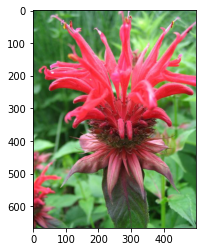

第 2 朵花预测:blackberry


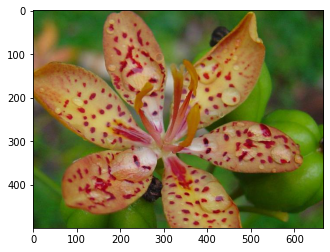

第 3 朵花预测:blanket


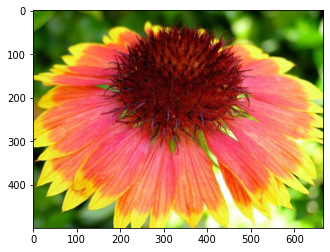

第 4 朵花预测:bougainvillea


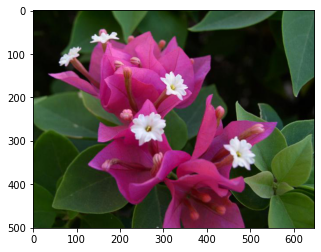

第 5 朵花预测:bougainvillea


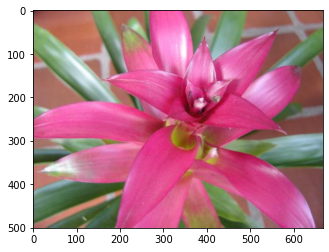

第 6 朵花预测:foxglove


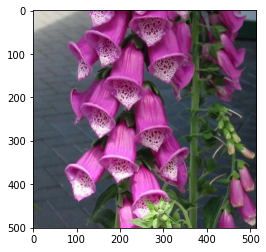

In [31]:
# prediction = model.predict_classes(imgs)      #将图像导入模型进行预测
prediction = np.argmax(model.predict(imgs), axis=1)
#绘制预测图像
for i in range(np.size(prediction)):
    #打印每张图像的预测结果
    print("第",i+1,"朵花预测:"+flower_dict[prediction[i]])  # flower_dict:定义的标签列表，prediction[i]：预测的结果
    img = plt.imread(path_test+"test"+str(i+1)+".jpg")      # 使用imread()函数读入对应的图片
    #img = plt.imread(path_test)
    plt.imshow(img)              #展示图片
    plt.show()                   #显示图片